<a href="https://colab.research.google.com/github/ElenaIurchenkoMatlas/twitterelection_dataanalysis/blob/main/Topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
# Import the datetime module
from datetime import datetime

from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import torch
from transformers import BertTokenizer, BertModel

In [ ]:
# Define file paths in Google Drive
file_path_biden = r"/content/drive/MyDrive/DataAnalysisTwitterElection2020/df_joebiden_topics_bert.csv"
file_path_trump = r"/content/drive/MyDrive/DataAnalysisTwitterElection2020/df_donaldtrump_topics_bert.csv"

# Read the CSVs correctly
df_donaldtrump = pd.read_csv(file_path_trump)
df_joebiden = pd.read_csv(file_path_biden)

In [ ]:
df_joebiden.shape

(311174, 31)

In [ ]:
df_donaldtrump.shape

(246364, 31)

In [ ]:
#dtype to datetime
df_joebiden['user_join_date'] = pd.to_datetime(df_joebiden['user_join_date'])
df_donaldtrump['user_join_date'] = pd.to_datetime(df_donaldtrump['user_join_date'])



In [ ]:
#reference date as the election day, November 3, 2020
reference_date = datetime(2020, 11, 3)

# Calculate the time difference in days from the reference date
df_joebiden['days_since_joined'] = (reference_date - df_joebiden['user_join_date']).dt.days
df_donaldtrump['days_since_joined'] = (reference_date - df_donaldtrump['user_join_date']).dt.days

# Classify users into groups based on time since joining as of November 3, 2020
df_joebiden['user_age_group'] = pd.cut(
    df_joebiden['days_since_joined'],
    bins=[0, 180, 365, float('inf')],  # 0 to 6 months, 6 months to 1 year, more than 1 year
    labels=['>6-month', '6_month-1year', '<1year'],
    right=False  # exclude the right edge to avoid overlapping intervals
)

df_donaldtrump['user_age_group'] = pd.cut(
    df_donaldtrump['days_since_joined'],
    bins=[0, 180, 365, float('inf')],  # 0 to 6 months, 6 months to 1 year, more than 1 year
    labels=['>6-month', '6_month-1year', '<1year'],
    right=False  # exclude the right edge to avoid overlapping intervals
)

# Drop the 'days_since_joined' column if you don’t need it in the final DataFrame
df_joebiden = df_joebiden.drop(columns=['days_since_joined'])
df_donaldtrump = df_donaldtrump.drop(columns=['days_since_joined'])

In [ ]:
# Combine both DataFrames to analyze sentiment and topics for both candidates together
df_combined = pd.concat([df_joebiden, df_donaldtrump], keys=['Joe Biden', 'Donald Trump'], names=['candidate'])

In [ ]:
df_combined['created_at'] = pd.to_datetime(df_combined['created_at'])

In [ ]:
# Reset the index to make 'candidate' a column
df_combined = df_combined.reset_index(level='candidate', drop=False)

In [ ]:
df_combined

candidate          created_at  \
0          Joe Biden 2020-10-15 00:00:02   
1          Joe Biden 2020-10-15 00:00:08   
2          Joe Biden 2020-10-15 00:00:17   
3          Joe Biden 2020-10-15 00:00:18   
4          Joe Biden 2020-10-15 00:00:20   
...              ...                 ...   
246359  Donald Trump 2020-11-08 23:58:27   
246360  Donald Trump 2020-11-08 23:58:48   
246361  Donald Trump 2020-11-08 23:58:56   
246362  Donald Trump 2020-11-08 23:59:16   
246363  Donald Trump 2020-11-08 23:59:38   

                                                    tweet  retweet_count  \
0       #Trump: As a student I used to hear for years,...            1.0   
1       You get a tie! And you get a tie! #Trump ‘s ra...            3.0   
2       @CLady62 Her 15 minutes were over long time ag...            0.0   
3       @DeeviousDenise @realDonaldTrump @nypost There...            0.0   
4       One of the single most effective remedies to e...            0.0   
...                                                   ...            ...   
246359   #Nationals invite #Biden https://t.co/UVEs3CB6mM            0.0   
246360  The man needs some help...#usa #biden\nWhen wi...            0.0   
246361  LIONZ DEN PRESENTS TO YOU \n\n“THE WHITE OBAMA...            0.0   
246362  Mr. #Biden, tear down that wall (with #Mexico)...            0.0   
246363  Stop laying @CNN !\n#Paris and #London dont gi...            0.0   

       user_screen_name      user_join_date                 user_location  \
0                snarke 2007-08-26 05:56:11                      Portland   
1             Ranaabtar 2009-06-15 19:05:35                 Washington DC   
2           FarrisFlagg 2013-02-01 01:37:38             Perris,California   
3           sm_gulledge 2017-08-24 16:45:49                     Ohio, USA   
4              jamieo33 2012-03-30 00:30:54             Pennsylvania, USA   
...                 ...                 ...                           ...   
246359  DisguiseDevilin 2015-12-22 21:52:34                   Terre/Earth   
246360    DrJoeMcCarthy 2020-04-09 00:34:23  Earth. 3rd Planet from Sun.    
246361    IUICMinnesota 2018-04-19 04:23:01                Minnesota, USA   
246362        TimFWelch 2011-09-21 07:13:23                  Auckland, NZ   
246363         flaquet1 2011-10-08 22:42:56                         PARIS   

            country      continent                 state  ... sentiment_vader  \
0               USA  North America                Oregon  ...        positive   
1               USA  North America  District of Columbia  ...         neutral   
2               USA  North America            California  ...        negative   
3               USA  North America                  Ohio  ...        positive   
4               USA  North America          Pennsylvania  ...        positive   
...             ...            ...                   ...  ...             ...   
246359     Ethiopia         Africa         Oromia Region  ...        negative   
246360          USA  North America                 Idaho  ...         neutral   
246361          USA  North America             Minnesota  ...        positive   
246362  New Zealand        Oceania              Auckland  ...         neutral   
246363       France         Europe         Ile-de-France  ...        negative   

        sentiment_score_vader  sentiment_tbl  sentiment_score_tbl  \
0                        68.1       positive                 66.7   
1                        50.0        neutral                 50.0   
2                        30.9       negative                 44.6   
3                        63.7       positive                 52.5   
4                        73.8       positive                 55.5   
...                       ...            ...                  ...   
246359                   20.7        neutral                 50.0   
246360                   50.0        neutral                 50.0   
246361                   95.3       positive      

<ipython-input-12-cbbdf358611c>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topic_sentiment = df_combined.groupby(['topic_lda', 'user_age_group']).agg({


   topic_lda user_age_group  sentiment_score  tweet_count
0          0       >6-month         0.260546         4689
1          0  6_month-1year         0.237374         3582
2          0         <1year         0.241855        70815
3          1       >6-month         0.299927        16149
4          1  6_month-1year         0.291468        11593


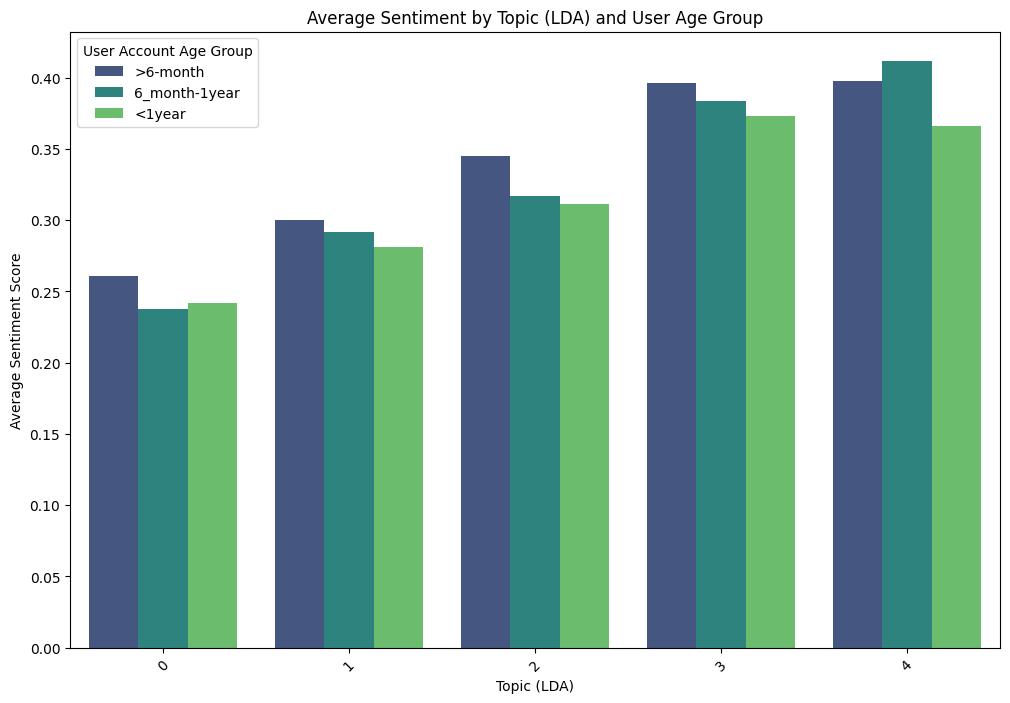

In [ ]:
# Group by topic (using topic_lda), user age group, and calculate the average sentiment score
topic_sentiment = df_combined.groupby(['topic_lda', 'user_age_group']).agg({
    'sentiment_score': 'mean',  # Calculate mean sentiment for each group
    'topic_lda': 'size'         # Count the number of tweets per topic
}).rename(columns={'topic_lda': 'tweet_count'}).reset_index()

# Display the aggregated results
print(topic_sentiment.head())

# Visualization: Average Sentiment by Topic and User Age Group
plt.figure(figsize=(12, 8))
sns.barplot(data=topic_sentiment, x='topic_lda', y='sentiment_score', hue='user_age_group', palette='viridis')
plt.title('Average Sentiment by Topic (LDA) and User Age Group')
plt.xlabel('Topic (LDA)')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.legend(title='User Account Age Group')
plt.show()

<ipython-input-13-20e3edf33734>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topic_sentiment_bert = df_combined.groupby(['topic_bert', 'user_age_group']).agg({



Top 5 Topics BERT Sentiment Analysis:
    topic_bert user_age_group  sentiment_score  tweet_count
0           -1       >6-month         0.299678        22161
1           -1  6_month-1year         0.281495        16251
2           -1         <1year         0.276394       321624
3            0       >6-month         0.188280          345
4            0  6_month-1year         0.127704          351
5            0         <1year         0.171965         5826
6            1       >6-month         0.193443          298
7            1  6_month-1year         0.195467          231
8            1         <1year         0.203670         4231
9            2       >6-month         0.288857          132
10           2  6_month-1year         0.252277          107
11           2         <1year         0.272232         1657
12           3       >6-month         0.427534          149
13           3  6_month-1year         0.513066           73
14           3         <1year         0.422310         1559


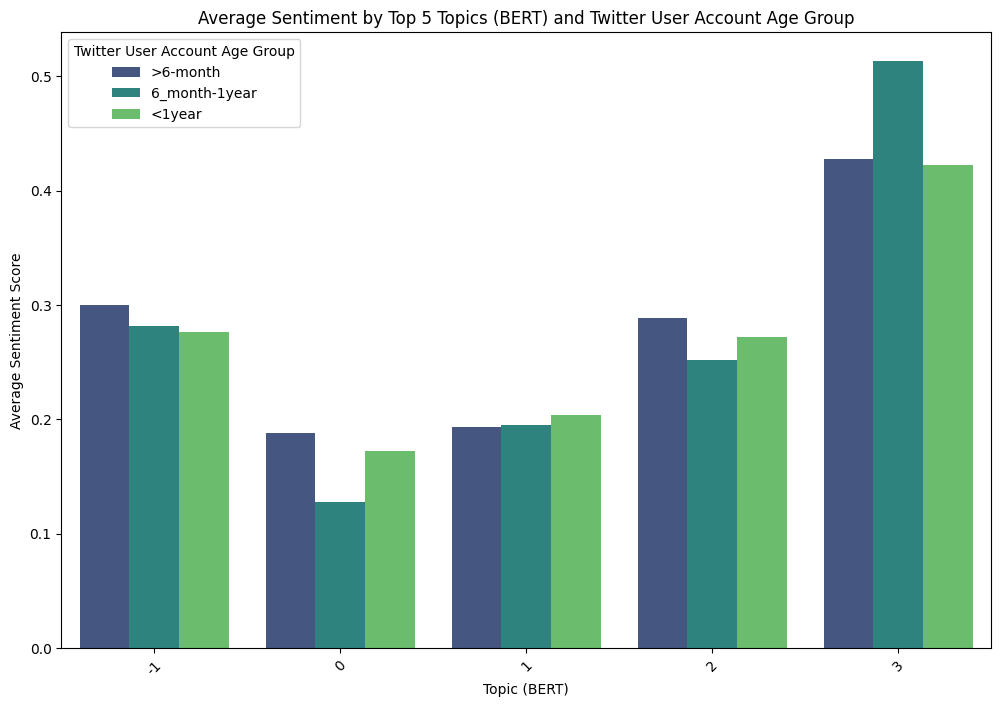

In [ ]:
# Group by topic (using topic_bert), user age group, and calculate the average sentiment score
topic_sentiment_bert = df_combined.groupby(['topic_bert', 'user_age_group']).agg({
    'sentiment_score': 'mean',  # Calculate mean sentiment for each group
    'topic_bert': 'size'        # Count the number of tweets per topic
}).rename(columns={'topic_bert': 'tweet_count'}).reset_index()

# Find the top 5 topics with the highest tweet counts
top_topics_bert = topic_sentiment_bert.groupby('topic_bert')['tweet_count'].sum().nlargest(5).index

# Filter to include only the top 5 topics
top_topic_sentiment_bert = topic_sentiment_bert[topic_sentiment_bert['topic_bert'].isin(top_topics_bert)]

# Display the aggregated results for the top topics
print("\nTop 5 Topics BERT Sentiment Analysis:")
print(top_topic_sentiment_bert)

# Visualization: Average Sentiment by Top 5 Topics (BERT) and Twitter User Account Age Group
plt.figure(figsize=(12, 8))
sns.barplot(data=top_topic_sentiment_bert, x='topic_bert', y='sentiment_score', hue='user_age_group', palette='viridis')
plt.title('Average Sentiment by Top 5 Topics (BERT) and Twitter User Account Age Group')
plt.xlabel('Topic (BERT)')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.legend(title='Twitter User Account Age Group')
plt.show()

In [ ]:
df_combined.columns

Index(['candidate', 'created_at', 'tweet', 'retweet_count', 'user_screen_name',
       'user_join_date', 'user_location', 'country', 'continent', 'state',
       'state_code', 'tweet_id', 'likes', 'user_id', 'user_followers_count',
       'lat', 'long', 'emojis', 'cleaned_tweet', 'detected_language',
       'tokenized_eng_tweet', 'hashtags', 'lemmatized_en_tweet',
       'sentiment_vader', 'sentiment_score_vader', 'sentiment_tbl',
       'sentiment_score_tbl', 'sentiment_agreement', 'sentiment_bert',
       'sentiment_score', 'topic_lda', 'topic_bert', 'user_age_group'],
      dtype='object')

Topic keyword detection

In [ ]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Step 1: Extract tweets by topic
topic_groups = df_combined.groupby('topic_bert')['lemmatized_en_tweet'].apply(list)

# Step 2: Compute TF-IDF scores for each topic
tfidf = TfidfVectorizer(stop_words='english')
representative_words = {}

for topic, tweets in topic_groups.items():
    # Join the list of tweets into a single text for TF-IDF computation
    text = ' '.join(tweets)
    tfidf_matrix = tfidf.fit_transform([text])
    feature_names = tfidf.get_feature_names_out()
    scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

    # Create a dictionary of words and their scores
    word_scores = dict(zip(feature_names, scores))

    # Get the top words
    top_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    representative_words[topic] = [word for word, score in top_words]

# Step 3: Obtain embeddings and select a representative word using BERT
selected_representative_words = {}
for topic, words in representative_words.items():
    # Filter words that exist in word_scores
    valid_words = [word for word in words if word in word_scores]

    if valid_words:  # Ensure there are valid words to process
        # Encode words using BERT tokenizer
        inputs = tokenizer(valid_words, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()  # Mean pooling

        # Select the word with the highest TF-IDF score as the representative
        representative_index = np.argmax([word_scores[word] for word in valid_words])
        selected_representative_words[topic] = valid_words[representative_index]
    else:
        selected_representative_words[topic] = None  # Handle cases with no valid words

# Step 4: Create a new DataFrame with topics and their representative words
representative_df = pd.DataFrame(list(selected_representative_words.items()), columns=['topic_bert', 'representative_word'])

# Merge with the original DataFrame if needed
df_combined = df_combined.merge(representative_df, on='topic_bert', how='left')

# Display the updated DataFrame
print(df_combined[['topic_bert', 'representative_word']].drop_duplicates())

        topic_bert representative_word
0               -1            election
1               34              people
6               10                vote
9              446                None
10             150                None
...            ...                 ...
276635        1628            american
282466        1830                None
286701        2153                None
294124        2152            election
295089        1861                None

[3077 rows x 2 columns]


In [ ]:
df_combined.head()

candidate          created_at  \
0  Joe Biden 2020-10-15 00:00:02   
1  Joe Biden 2020-10-15 00:00:08   
2  Joe Biden 2020-10-15 00:00:17   
3  Joe Biden 2020-10-15 00:00:18   
4  Joe Biden 2020-10-15 00:00:20   

                                               tweet  retweet_count  \
0  #Trump: As a student I used to hear for years,...            1.0   
1  You get a tie! And you get a tie! #Trump ‘s ra...            3.0   
2  @CLady62 Her 15 minutes were over long time ag...            0.0   
3  @DeeviousDenise @realDonaldTrump @nypost There...            0.0   
4  One of the single most effective remedies to e...            0.0   

  user_screen_name      user_join_date      user_location country  \
0           snarke 2007-08-26 05:56:11           Portland     USA   
1        Ranaabtar 2009-06-15 19:05:35      Washington DC     USA   
2      FarrisFlagg 2013-02-01 01:37:38  Perris,California     USA   
3      sm_gulledge 2017-08-24 16:45:49          Ohio, USA     USA   
4         jamieo33 2012-03-30 00:30:54  Pennsylvania, USA     USA   

       continent                 state  ... sentiment_score_vader  \
0  North America                Oregon  ...                  68.1   
1  North America  District of Columbia  ...                  50.0   
2  North America            California  ...                  30.9   
3  North America                  Ohio  ...                  63.7   
4  North America          Pennsylvania  ...                  73.8   

   sentiment_tbl  sentiment_score_tbl  sentiment_agreement  sentiment_bert  \
0       positive                 66.7                 True        negative   
1        neutral                 50.0                 True        negative   
2       negative                 44.6                 True        negative   
3       positive                 52.5                 True        negative   
4       positive                 55.5                 True        negative   

   sentiment_score  topic_lda topic_bert user_age_group representative_word  
0         0.013582          1         -1         <1year            election  
1         0.033794          4         34         <1year              people  
2         0.003601          3         -1         <1year            election  
3         0.070799          1         -1         <1year            election  
4         0.050497          2         -1         <1year            election  

[5 rows x 34 columns]

In [ ]:
# Filter data for Biden and Trump
biden_data = df_combined[df_combined['candidate'] == 'Joe Biden']
trump_data = df_combined[df_combined['candidate'] == 'Donald Trump']

# Identify the top 5 topics for both candidates
top_biden_topics = biden_data['topic_bert'].value_counts().nlargest(5).index
top_trump_topics = trump_data['topic_bert'].value_counts().nlargest(5).index

# Filter the data for the top 5 topics
biden_topics = biden_data[biden_data['topic_bert'].isin(top_biden_topics)]
trump_topics = trump_data[trump_data['topic_bert'].isin(top_trump_topics)]


Sentiment and Topic Analysis Over Time:

group tweets by topic
calculate the average sentiment for each topic
Compare Sentiment Across User Groups
Listeneintrag

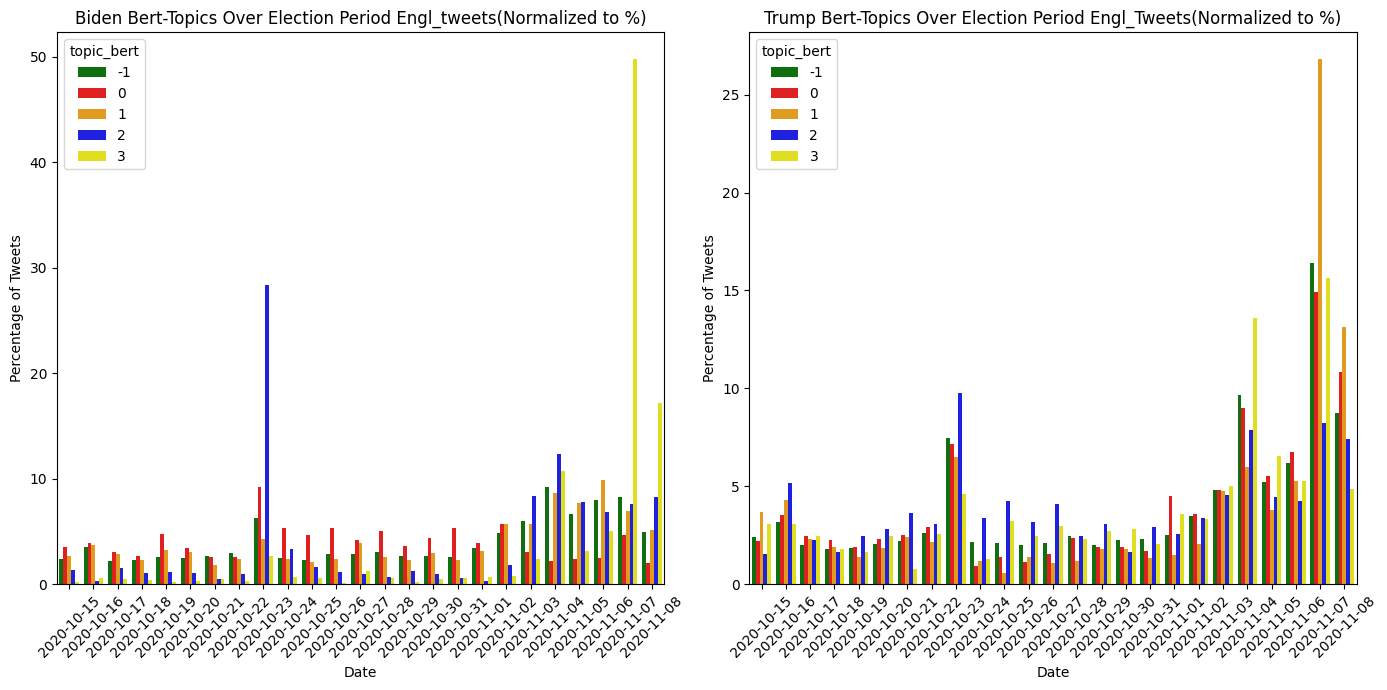

In [ ]:
# Prepare data for bar plot and normalize to percentages
biden_topic_counts = biden_topics.groupby(['topic_bert', biden_topics['created_at'].dt.date]).size().unstack(fill_value=0)
trump_topic_counts = trump_topics.groupby(['topic_bert', trump_topics['created_at'].dt.date]).size().unstack(fill_value=0)

# Normalize to percentages
biden_topic_counts_normalized = biden_topic_counts.div(biden_topic_counts.sum(axis=1), axis=0) * 100
trump_topic_counts_normalized = trump_topic_counts.div(trump_topic_counts.sum(axis=1), axis=0) * 100

# Melt the DataFrame for easier plotting with Seaborn
biden_melted = biden_topic_counts_normalized.reset_index().melt(id_vars='topic_bert', var_name='date', value_name='percentage')
trump_melted = trump_topic_counts_normalized.reset_index().melt(id_vars='topic_bert', var_name='date', value_name='percentage')

# Define a color palette
custom_colors = ['green', 'red', 'orange', 'blue', 'yellow']

# Plotting
plt.figure(figsize=(14, 7))

# Bar plot for Biden
plt.subplot(1, 2, 1)
sns.barplot(data=biden_melted, x='date', y='percentage', hue='topic_bert', palette=custom_colors)
plt.title('Biden Bert-Topics Over Election Period Engl_tweets(Normalized to %)')
plt.xlabel('Date')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)

# Bar plot for Trump
plt.subplot(1, 2, 2)
sns.barplot(data=trump_melted, x='date', y='percentage', hue='topic_bert', palette=custom_colors)
plt.title('Trump Bert-Topics Over Election Period Engl_Tweets(Normalized to %)')
plt.xlabel('Date')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



Sentiments over election period for both candidates BERT vs VADER

Topic Popularity on Election Days


*   Topic Frequency Analysis
*   Topic Sentiment Trends: Track sentiment scores for each topic across different election days.



Extract the Most Frequent Words: Instead of displaying the full concatenated text, summarize or extract the most relevant keywords for each topic.

Create a Summary Table: Present the topics with their associated keywords in a structured format, making it easy to visualize.

Visualize with Word Clouds: Generate word clouds for each topic to give a visual representation of the keywords.

Biden's Topics of Interest with Keywords:

Topic: 3
Top Keywords: ["['congratulation',", "'president',", "'congratulation',", "'biden',", "'america',", "'u',", "['congrats',", "'congratulate',", "'world',", "'trump',"]

Topic: -1
Top Keywords: ["'trump',", "'amp',", "'vote',", "'like',", "'election',", "'people',", "'u',", "'president',", "'biden',", "'get',"]

Topic: 0
Top Keywords: ["'covid',", "'virus',", "'trump',", "'coronavirus',", "'case',", "'people',", "'vaccine',", "'death',", "'pandemic',", "'u',"]

Topic: 1
Top Keywords: ["'republican',", "'party',", "'democrat',", "'vote',", "['republican',", "'trump',", "'people',", "'election',", "'like',", "['democrat',"]

Topic: 2
Top Keywords: ["'india',", "'filthy',", "'trump',", "'indian',", "'u',", "'air',", "'modi',", "'amp',", "'president',", "['india',"]

Trump's Topics of Interest with Keywords:

Topic: 3
Top Keywords: ["'white',", "'racist',", "'black',", "'people',", "'fascist',", "'amp',", "'racism',", "'vote',", "'supremaci

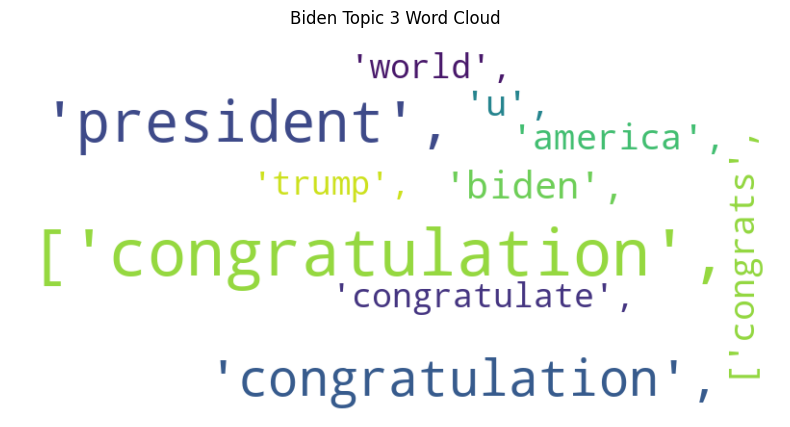

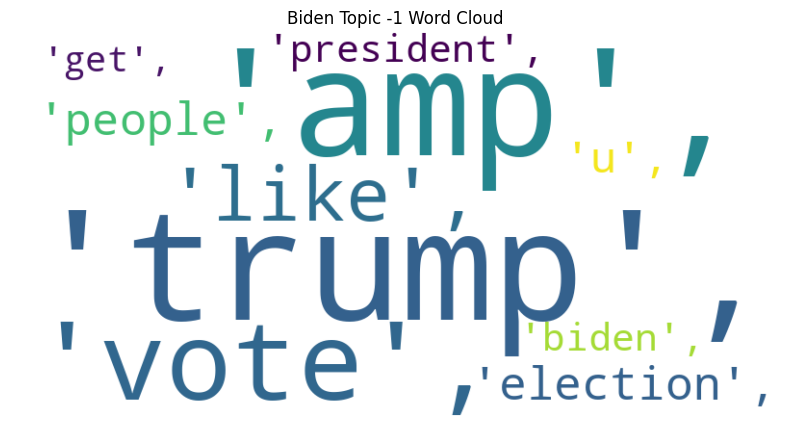

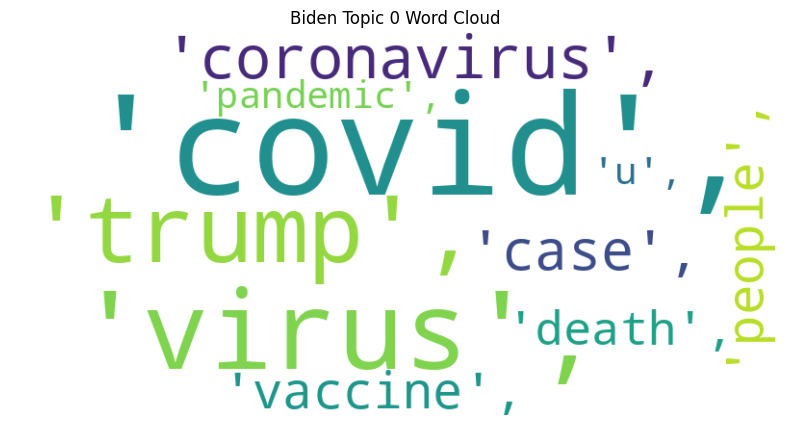

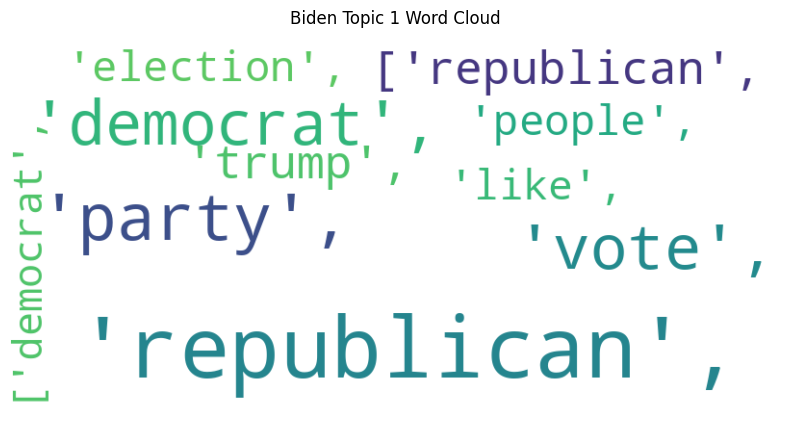

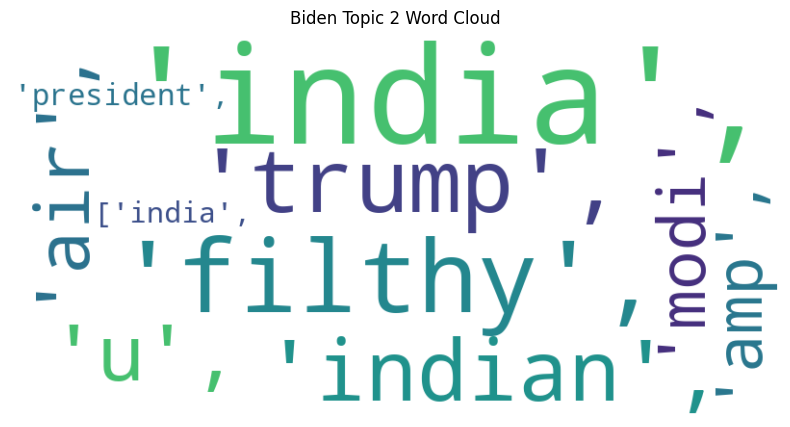

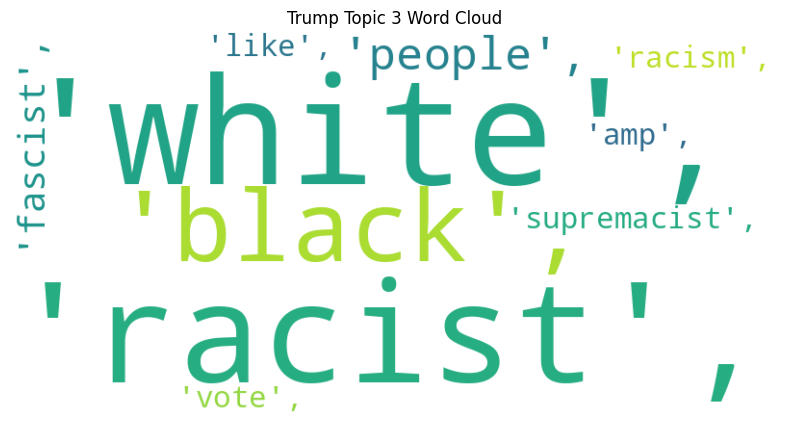

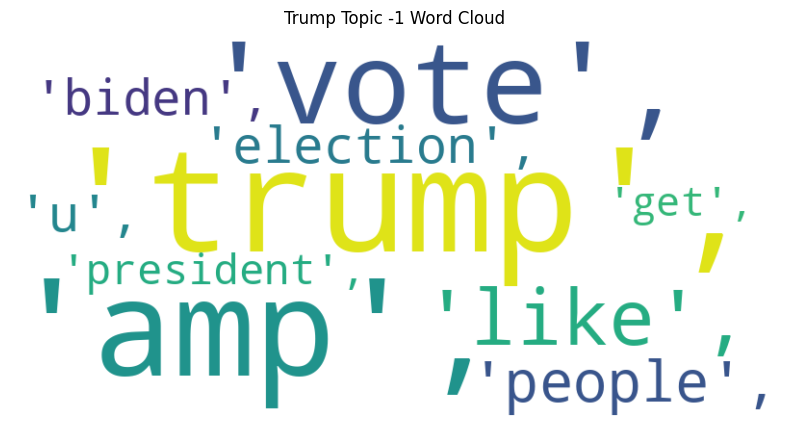

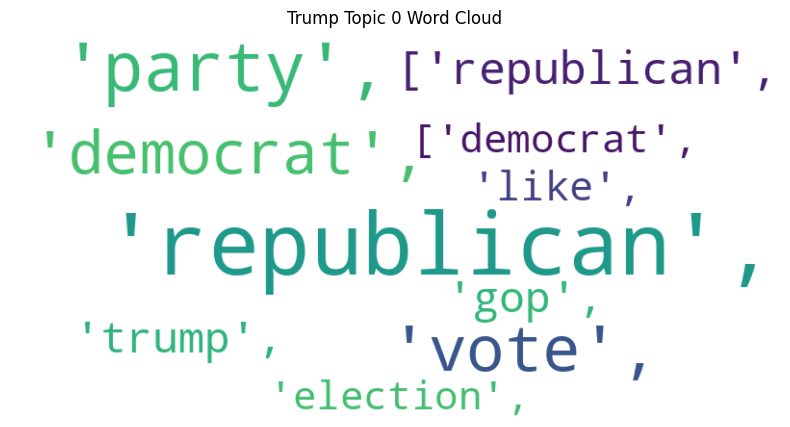

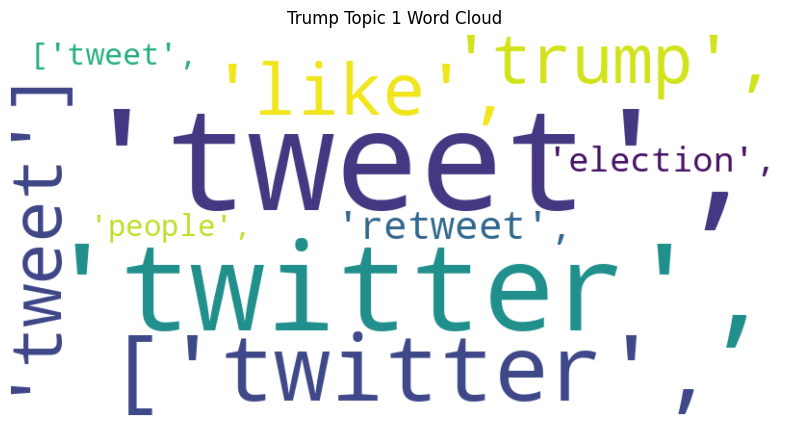

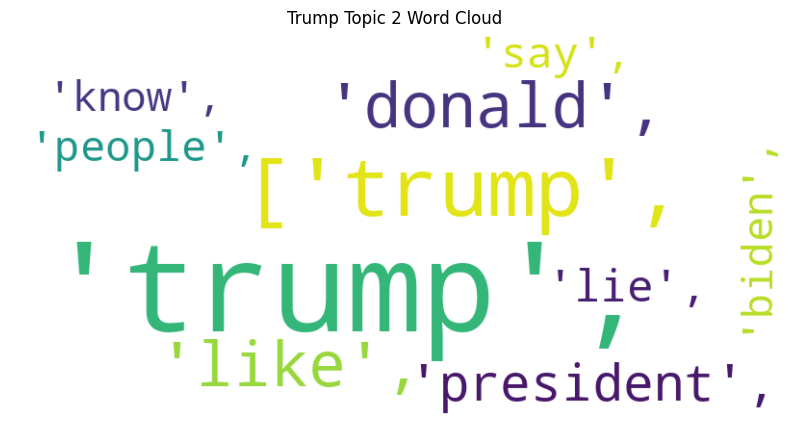

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to extract keywords (top N words) for each topic
def extract_top_keywords(tweets, top_n=10):
    # Tokenize the tweets and count the frequency of each word
    words = ' '.join(tweets).split()
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

# Specify the topics of interest
biden_interested_topics = [top_biden_topics[-1], top_biden_topics[0],top_biden_topics[1], top_biden_topics[2],top_biden_topics[3]]
trump_interested_topics = [top_trump_topics[-1], top_trump_topics[0], top_trump_topics[1], top_trump_topics[2], top_trump_topics[3]]

# Extract top keywords for Biden's topics using the lemmatized_en_tweet column
biden_topic_keywords = {}
for topic in biden_interested_topics:
    related_tweets = biden_data[biden_data['topic_bert'] == topic]['lemmatized_en_tweet']
    top_keywords = extract_top_keywords(related_tweets)
    biden_topic_keywords[topic] = top_keywords

# Extract top keywords for Trump's topics using the lemmatized_en_tweet column
trump_topic_keywords = {}
for topic in trump_interested_topics:
    related_tweets = trump_data[trump_data['topic_bert'] == topic]['lemmatized_en_tweet']
    top_keywords = extract_top_keywords(related_tweets)
    trump_topic_keywords[topic] = top_keywords

# Print the summarized topics and keywords
print("Biden's Topics of Interest with Keywords:")
for topic, keywords in biden_topic_keywords.items():
    print(f"\nTopic: {topic}")
    print("Top Keywords:", [word for word, _ in keywords])

print("\nTrump's Topics of Interest with Keywords:")
for topic, keywords in trump_topic_keywords.items():
    print(f"\nTopic: {topic}")
    print("Top Keywords:", [word for word, _ in keywords])

# Function to create a word cloud for each topic
def create_word_cloud(keywords, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(keywords))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for Biden's topics
for topic, keywords in biden_topic_keywords.items():
    create_word_cloud(keywords, f"Biden Topic {topic} Word Cloud")

# Generate word clouds for Trump's topics
for topic, keywords in trump_topic_keywords.items():
    create_word_cloud(keywords, f"Trump Topic {topic} Word Cloud")

4. Cross-Referencing Sentiment with User Age and Location
Geographic Analysis: For each topic, analyze the sentiment based on user_location, country, or continent. This can reveal if users from specific regions reacted differently to various topics.
Engagement by User Group and Location: Calculate the number of tweets per topic from old and new users, segmented by location.

5. Advanced Techniques (Optional)
Clustering for Subgroups: Using clustering on sentiment and topic vectors (especially from topic_bert embeddings) could identify hidden patterns among different types of users.
Time Series Forecasting: If you have sufficient historical data, you might explore time-series analysis to predict which topics might become popular on future election days.

Topics over USA states

In [ ]:
# List of the 50 U.S. states
us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
    'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
    'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
    'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

# Filter for USA and the 50 U.S. states in the combined dataset
filtered_df_combined = df_combined[
    (df_combined['country'] == 'USA') & (df_combined['state'].isin(us_states))
]

# Separate data for each candidate
biden_data = filtered_df_combined[filtered_df_combined['candidate'] == 'Joe Biden']
trump_data = filtered_df_combined[filtered_df_combined['candidate'] == 'Donald Trump']

# Find the top 5 topics for Biden
top_5_biden_topics = biden_data['topic_bert'].value_counts().nlargest(5).index
biden_top_topics = biden_data[biden_data['topic_bert'].isin(top_5_biden_topics)]

# Find the top 5 topics for Trump
top_5_trump_topics = trump_data['topic_bert'].value_counts().nlargest(5).index
trump_top_topics = trump_data[trump_data['topic_bert'].isin(top_5_trump_topics)]

# Aggregate by state and topic for Biden
biden_topic_distribution = biden_top_topics.groupby(['state', 'topic_bert']).size().unstack(fill_value=0)

# Aggregate by state and topic for Trump
trump_topic_distribution = trump_top_topics.groupby(['state', 'topic_bert']).size().unstack(fill_value=0)

# Normalize by row (state) to get proportions for each candidate's data
biden_topic_distribution_normalized = biden_topic_distribution.div(biden_topic_distribution.sum(axis=1), axis=0)
trump_topic_distribution_normalized = trump_topic_distribution.div(trump_topic_distribution.sum(axis=1), axis=0)

# Sort states by the highest value in the most represented topic for each candidate
biden_topic_distribution_sorted = biden_topic_distribution_normalized.loc[
    biden_topic_distribution_normalized.max(axis=1).sort_values(ascending=False).index
]

trump_topic_distribution_sorted = trump_topic_distribution_normalized.loc[
    trump_topic_distribution_normalized.max(axis=1).sort_values(ascending=False).index
]



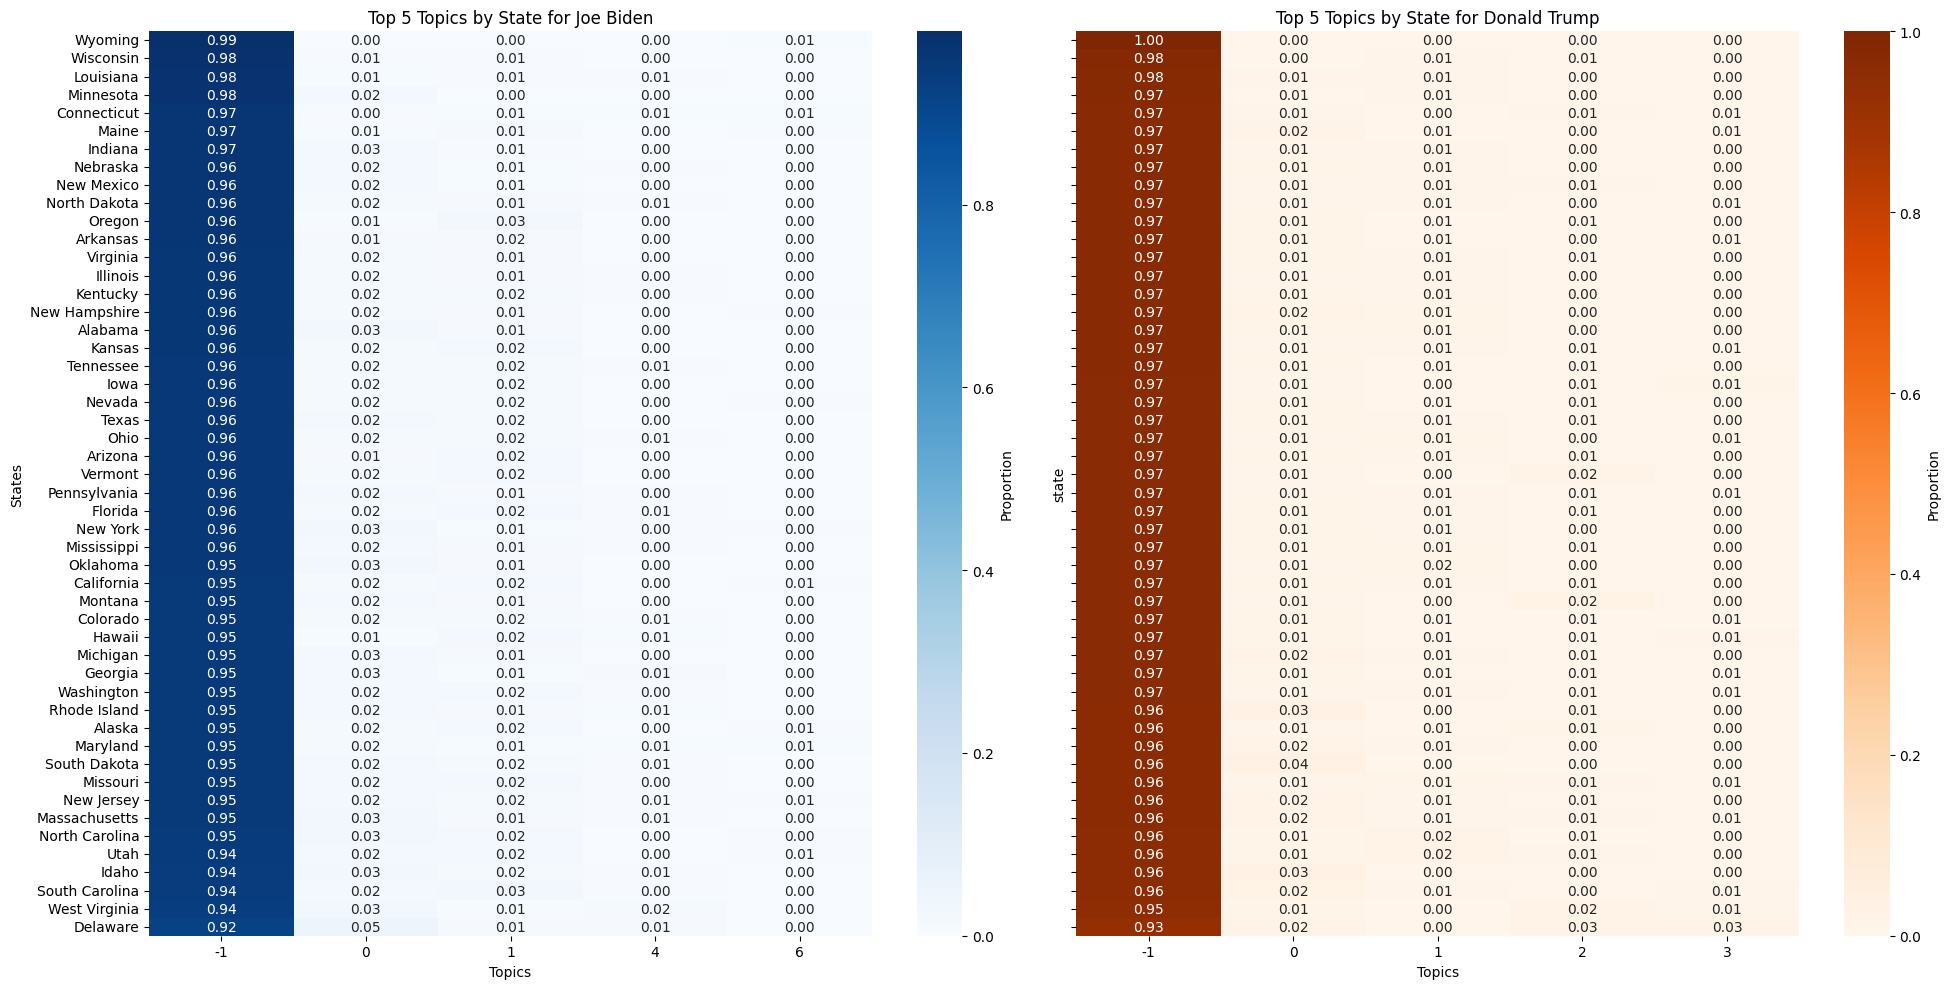

In [ ]:
# Visualize the results for Biden and Trump in separate heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Plot for Biden
sns.heatmap(biden_topic_distribution_sorted, cmap="Blues", ax=axes[0], annot=True, fmt=".2f", cbar_kws={'label': 'Proportion'})
axes[0].set_title("Top 5 Topics by State for Joe Biden")
axes[0].set_xlabel("Topics")
axes[0].set_ylabel("States")

# Plot for Trump
sns.heatmap(trump_topic_distribution_sorted, cmap="Oranges", ax=axes[1], annot=True, fmt=".2f", cbar_kws={'label': 'Proportion'})
axes[1].set_title("Top 5 Topics by State for Donald Trump")
axes[1].set_xlabel("Topics")

plt.tight_layout()
plt.show()

In [ ]:
# # Filter the data to include only tweets with topic_bert = -1 for each candidate
biden_topic_minus1 = biden_data[biden_data['topic_bert'] == -1]
trump_topic_minus1 = trump_data[trump_data['topic_bert'] == -1]

# # Concatenate all the tweets in topic -1 for each candidate
# biden_text = ' '.join(biden_topic_minus1['lemmatized_en_tweet'].tolist())
# trump_text = ' '.join(trump_topic_minus1['lemmatized_en_tweet'].tolist())

# # Generate word frequency counts for each candidate
# biden_word_counts = Counter(biden_text.split())
# trump_word_counts = Counter(trump_text.split())

# # Display most common words for Biden
# print("Top words in topic -1 for Biden:")
# print(biden_word_counts.most_common(10))

# # Display most common words for Trump
# print("Top words in topic -1 for Trump:")
# print(trump_word_counts.most_common(10))

# # Generate word clouds for visualization
# plt.figure(figsize=(16, 8))

# # Word cloud for Biden
# plt.subplot(1, 2, 1)
# wordcloud_biden = WordCloud(width=800, height=400, background_color='white').generate(biden_text)
# plt.imshow(wordcloud_biden, interpolation='bilinear')
# plt.title("Most Common Words in Topic -1 (Joe Biden)")
# plt.axis('off')

# # Word cloud for Trump
# plt.subplot(1, 2, 2)
# wordcloud_trump = WordCloud(width=800, height=400, background_color='white').generate(trump_text)
# plt.imshow(wordcloud_trump, interpolation='bilinear')
# plt.title("Most Common Words in Topic -1 (Donald Trump)")
# plt.axis('off')

# plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# # Filter the data to include only tweets with topic_bert = -1 for each candidate
biden_topic_minus1 = biden_data[biden_data['topic_bert'] == -1]
trump_topic_minus1 = trump_data[trump_data['topic_bert'] == -1]
# Combine the text for Biden and Trump in topic -1
biden_topic_minus1_text = biden_topic_minus1['lemmatized_en_tweet'].tolist()
trump_topic_minus1_text = trump_topic_minus1['lemmatized_en_tweet'].tolist()

# All text for both candidates in topic -1 for TF-IDF calculation
all_text = biden_topic_minus1_text + trump_topic_minus1_text

# Create labels for each text (0 for Biden, 1 for Trump) to separate them after TF-IDF
labels = [0] * len(biden_topic_minus1_text) + [1] * len(trump_topic_minus1_text)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limit to top 1000 features to keep it manageable
tfidf_matrix = tfidf_vectorizer.fit_transform(all_text)

# Get the TF-IDF feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Separate TF-IDF results back into Biden and Trump
tfidf_biden = tfidf_matrix[0:len(biden_topic_minus1_text), :].mean(axis=0)
tfidf_trump = tfidf_matrix[len(biden_topic_minus1_text):, :].mean(axis=0)

# Convert to pandas DataFrame for easy manipulation

biden_tfidf_scores = pd.DataFrame(tfidf_biden.T, index=feature_names, columns=["tfidf_weight"]).sort_values(by="tfidf_weight", ascending=False)
trump_tfidf_scores = pd.DataFrame(tfidf_trump.T, index=feature_names, columns=["tfidf_weight"]).sort_values(by="tfidf_weight", ascending=False)


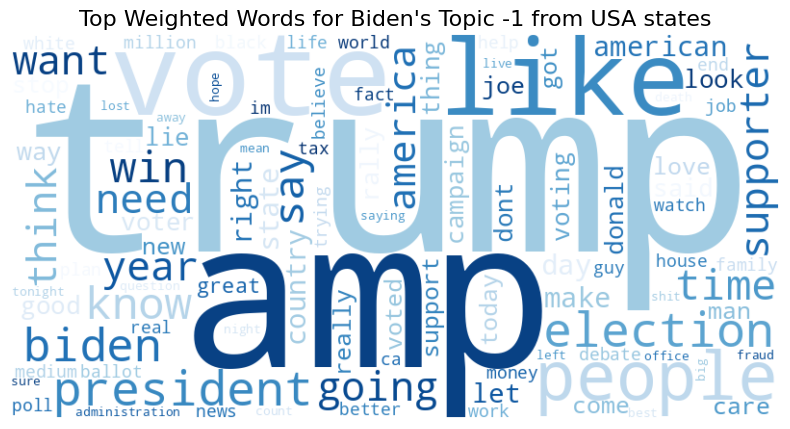

In [ ]:
# Function to generate and display a word cloud
def generate_word_cloud(tfidf_scores, title, color='blue'):
    # Convert TF-IDF scores to a dictionary format for WordCloud
    word_weights = tfidf_scores['tfidf_weight'].to_dict()

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color,
                          max_words=100).generate_from_frequencies(word_weights)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Generate word cloud for Biden
generate_word_cloud(biden_tfidf_scores, title="Top Weighted Words for Biden's Topic -1 from USA states", color='Blues')

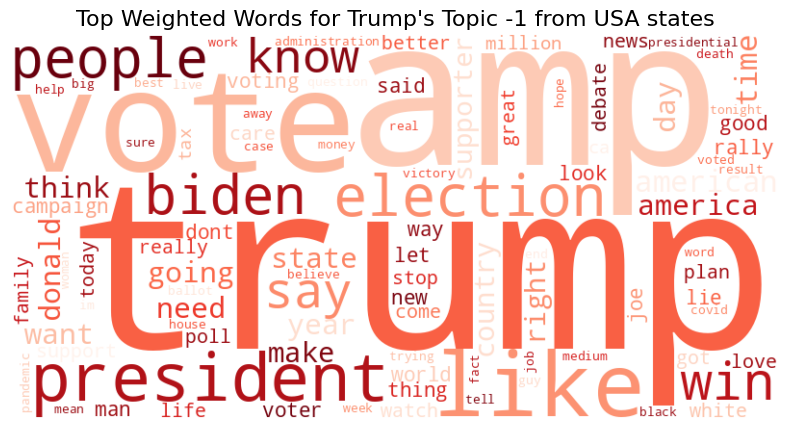

In [ ]:
generate_word_cloud(trump_tfidf_scores, title="Top Weighted Words for Trump's Topic -1 from USA states", color='Reds')

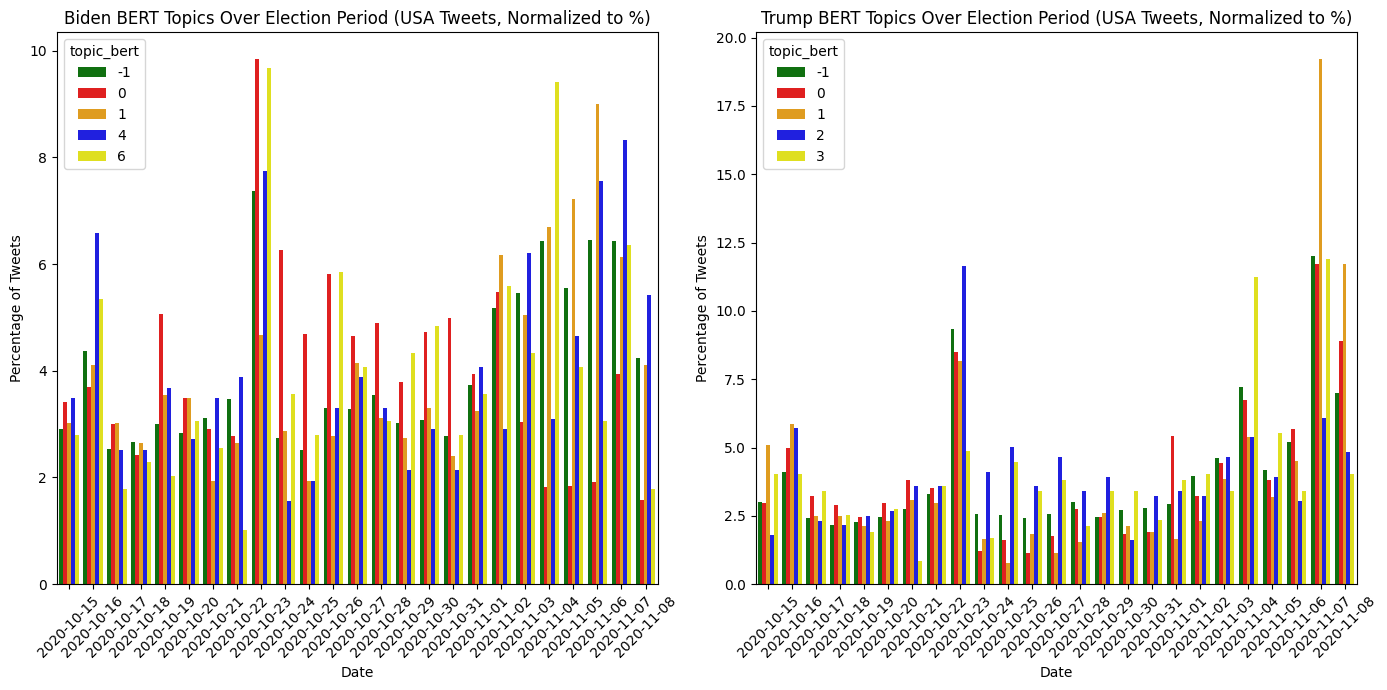

In [ ]:
# Filter data for Biden and Trump tweets from the USA
usa_data = df_combined[df_combined['country'] == 'USA']
biden_data = usa_data[usa_data['candidate'] == 'Joe Biden']
trump_data = usa_data[usa_data['candidate'] == 'Donald Trump']

# Identify the top 5 topics for both candidates
top_biden_topics = biden_data['topic_bert'].value_counts().nlargest(5).index
top_trump_topics = trump_data['topic_bert'].value_counts().nlargest(5).index

# Filter the data for the top 5 topics
biden_topics = biden_data[biden_data['topic_bert'].isin(top_biden_topics)]
trump_topics = trump_data[trump_data['topic_bert'].isin(top_trump_topics)]

# Prepare data for bar plot and normalize to percentages
biden_topic_counts = biden_topics.groupby(['topic_bert', biden_topics['created_at'].dt.date]).size().unstack(fill_value=0)
trump_topic_counts = trump_topics.groupby(['topic_bert', trump_topics['created_at'].dt.date]).size().unstack(fill_value=0)

# Normalize to percentages
biden_topic_counts_normalized = biden_topic_counts.div(biden_topic_counts.sum(axis=1), axis=0) * 100
trump_topic_counts_normalized = trump_topic_counts.div(trump_topic_counts.sum(axis=1), axis=0) * 100

# Melt the DataFrame for easier plotting with Seaborn
biden_melted = biden_topic_counts_normalized.reset_index().melt(id_vars='topic_bert', var_name='date', value_name='percentage')
trump_melted = trump_topic_counts_normalized.reset_index().melt(id_vars='topic_bert', var_name='date', value_name='percentage')

# Define a color palette
custom_colors = ['green', 'red', 'orange', 'blue', 'yellow']

# Plotting
plt.figure(figsize=(14, 7))

# Bar plot for Biden
plt.subplot(1, 2, 1)
sns.barplot(data=biden_melted, x='date', y='percentage', hue='topic_bert', palette=custom_colors)
plt.title('Biden BERT Topics Over Election Period (USA Tweets, Normalized to %)')
plt.xlabel('Date')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)

# Bar plot for Trump
plt.subplot(1, 2, 2)
sns.barplot(data=trump_melted, x='date', y='percentage', hue='topic_bert', palette=custom_colors)
plt.title('Trump BERT Topics Over Election Period (USA Tweets, Normalized to %)')
plt.xlabel('Date')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


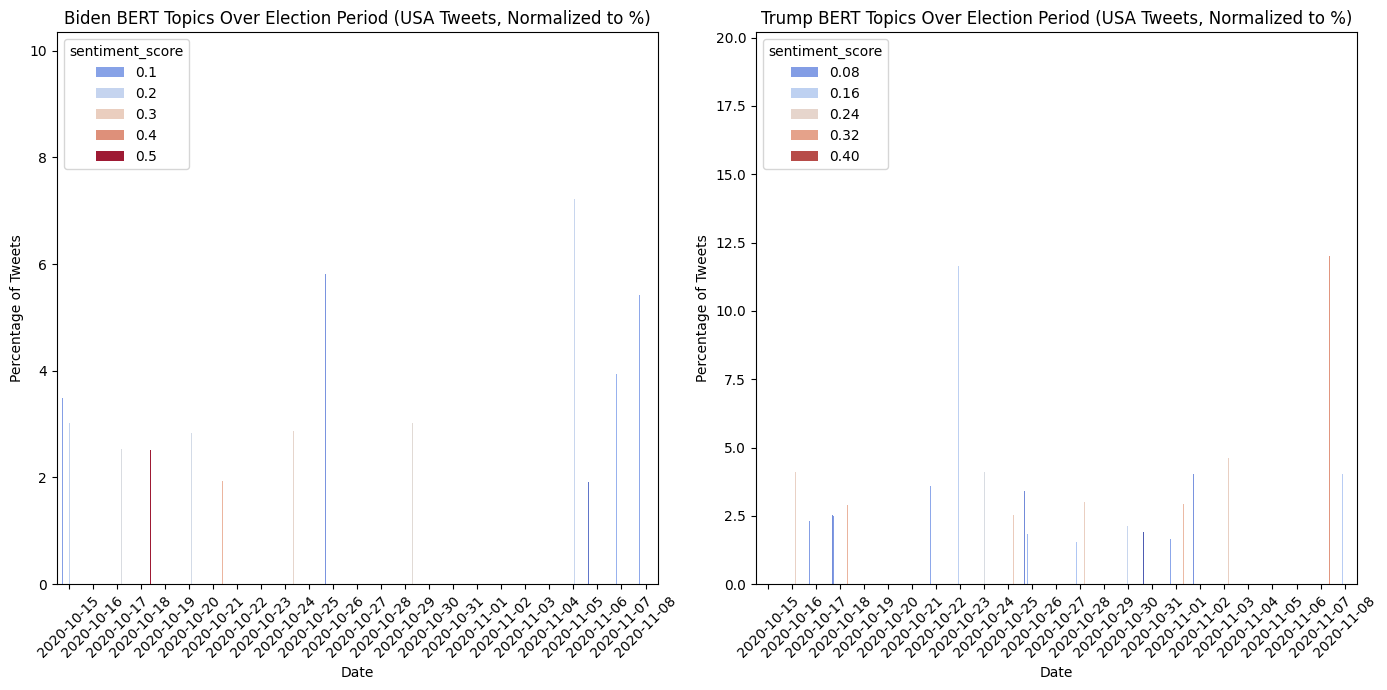

In [ ]:
# Step 1: Aggregate sentiment scores by topic and date
biden_sentiment = biden_topics.groupby(['topic_bert', biden_topics['created_at'].dt.date])['sentiment_score'].mean().reset_index()
biden_sentiment.columns = ['topic_bert', 'date', 'sentiment_score']

trump_sentiment = trump_topics.groupby(['topic_bert', trump_topics['created_at'].dt.date])['sentiment_score'].mean().reset_index()
trump_sentiment.columns = ['topic_bert', 'date', 'sentiment_score']

# Step 2: Merge sentiment scores with melted data
biden_melted = pd.merge(biden_melted, biden_sentiment, on=['topic_bert', 'date'], how='left')
trump_melted = pd.merge(trump_melted, trump_sentiment, on=['topic_bert', 'date'], how='left')

# Plot with sentiment as hue
plt.figure(figsize=(14, 7))

# Bar plot for Biden with sentiment hue
plt.subplot(1, 2, 1)
sns.barplot(data=biden_melted, x='date', y='percentage', hue='sentiment_score', palette="coolwarm")
plt.title('Biden BERT Topics Over Election Period (USA Tweets, Normalized to %)')
plt.xlabel('Date')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)

# Bar plot for Trump with sentiment hue
plt.subplot(1, 2, 2)
sns.barplot(data=trump_melted, x='date', y='percentage', hue='sentiment_score', palette="coolwarm")
plt.title('Trump BERT Topics Over Election Period (USA Tweets, Normalized to %)')
plt.xlabel('Date')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


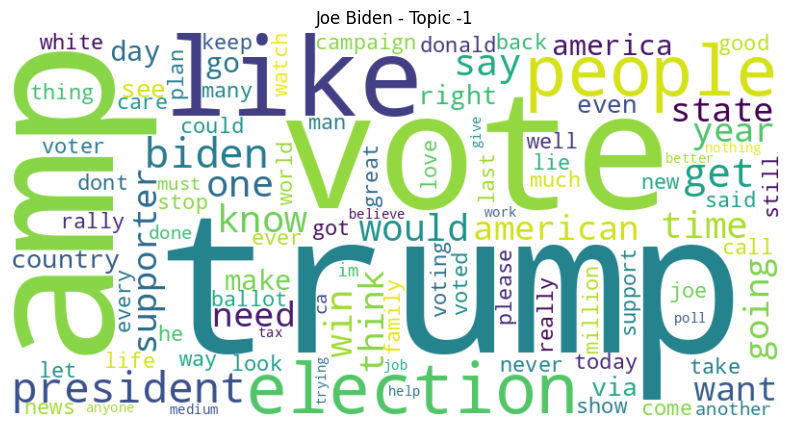

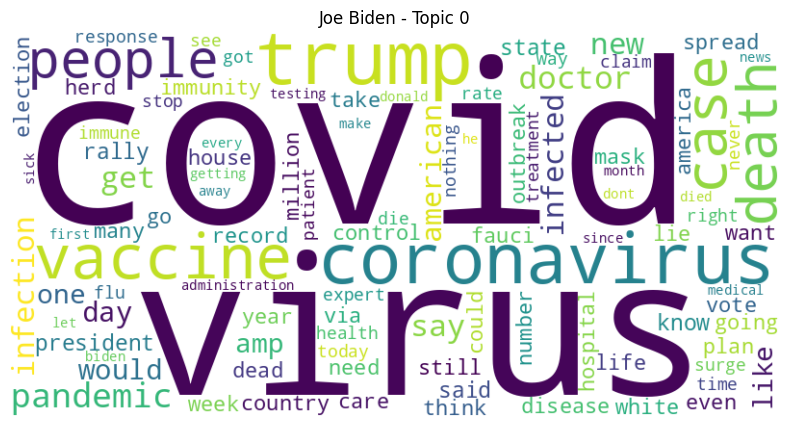

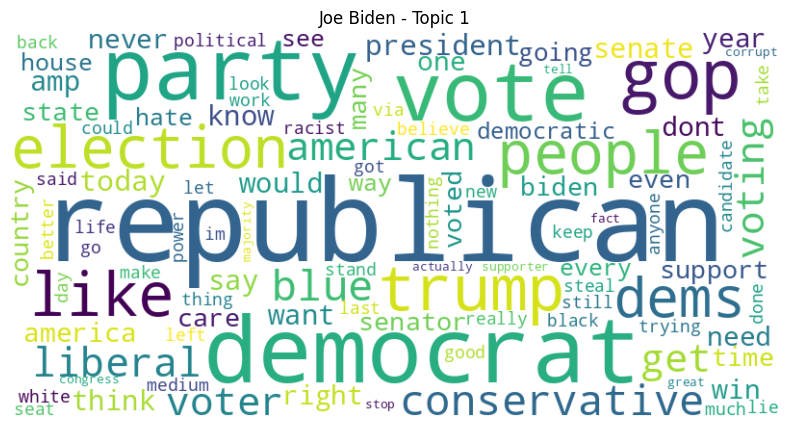

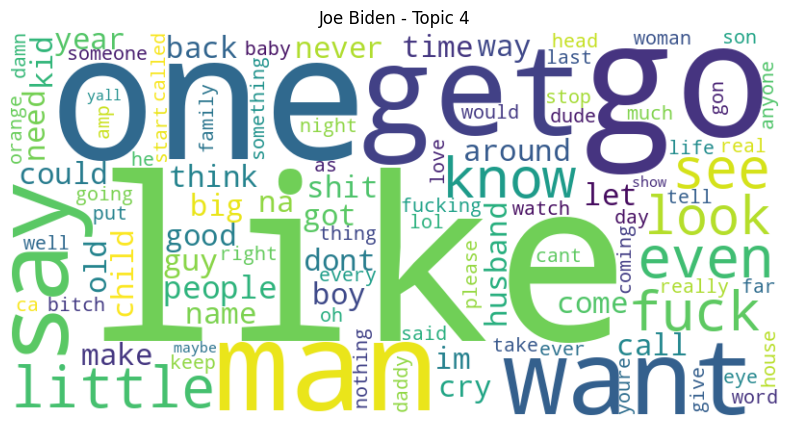

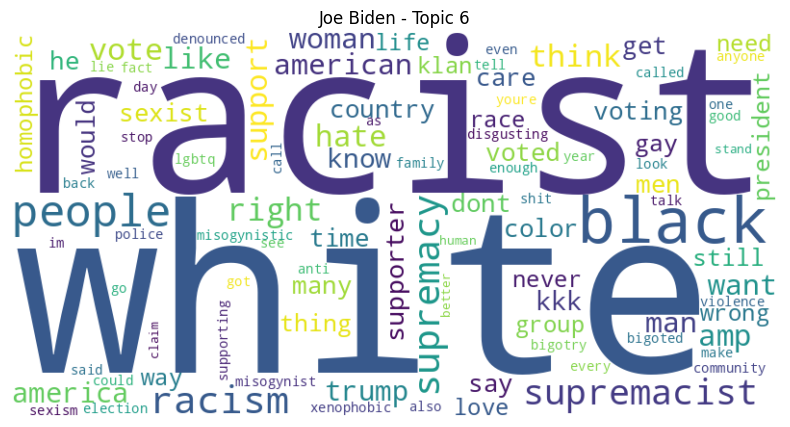

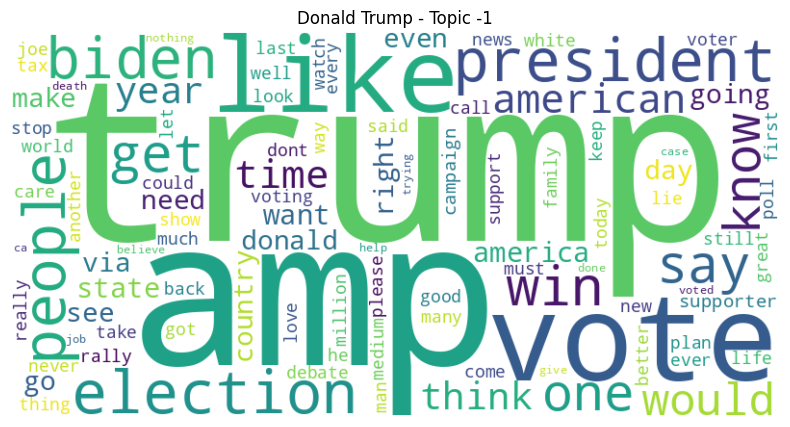

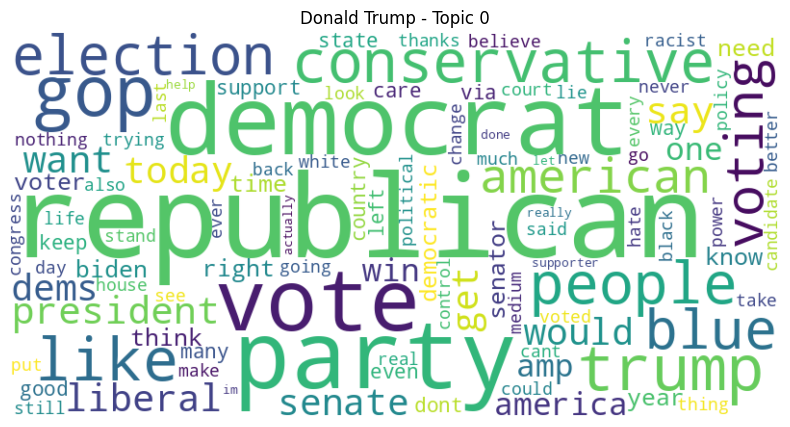

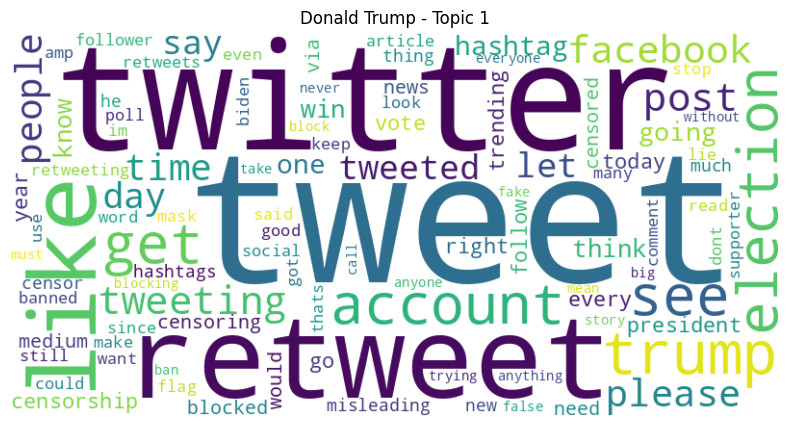

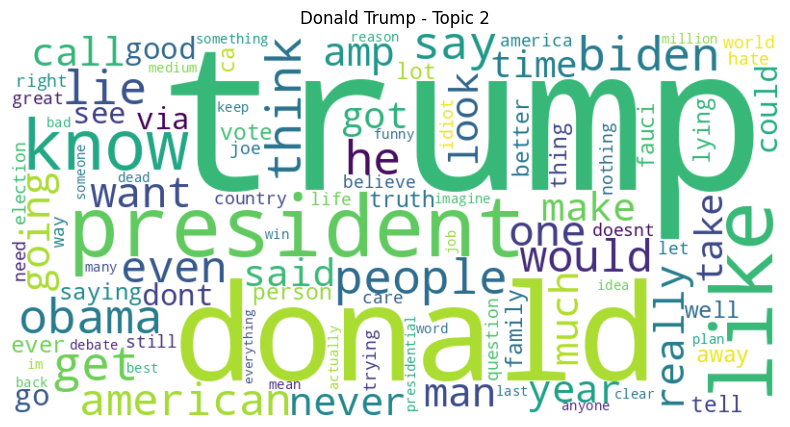

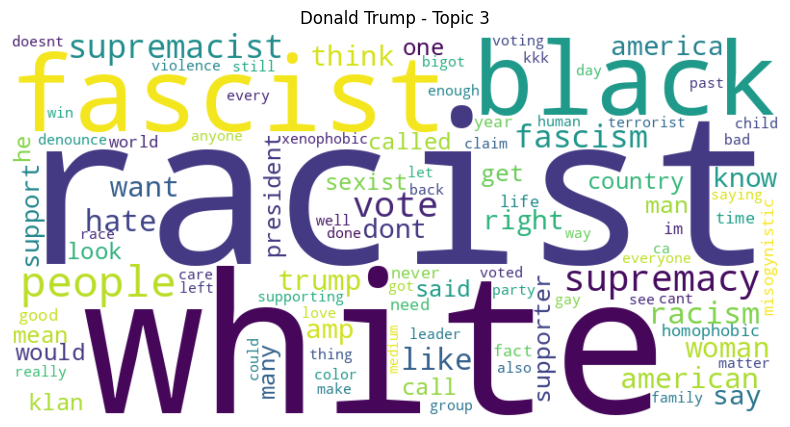

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter for tweets from the USA
biden_data_usa = biden_data[biden_data['country'] == 'USA']
trump_data_usa = trump_data[trump_data['country'] == 'USA']

# Function to generate TF-IDF and create a word cloud for each topic
def generate_topic_wordcloud(data, topics, candidate_name):
    for topic in topics:
        # Filter for the current topic
        topic_data = data[data['topic_bert'] == topic]

        # Apply TF-IDF on lemmatized tweets
        tfidf = TfidfVectorizer(max_features=100)  # Limit to top 100 words for clarity
        tfidf_matrix = tfidf.fit_transform(topic_data['lemmatized_en_tweet'])

        # Get words and their scores
        words = tfidf.get_feature_names_out()
        scores = tfidf_matrix.sum(axis=0).A1
        word_scores = dict(zip(words, scores))

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{candidate_name} - Topic {topic}")
        plt.show()

# Define main topics for Biden and Trump
biden_topics_list = [-1, 0, 1, 4, 6]
trump_topics_list = [-1, 0, 1, 2, 3]

# Generate word clouds for Biden's topics
generate_topic_wordcloud(biden_data_usa, biden_topics_list, 'Joe Biden')

# Generate word clouds for Trump's topics
generate_topic_wordcloud(trump_data_usa, trump_topics_list, 'Donald Trump')


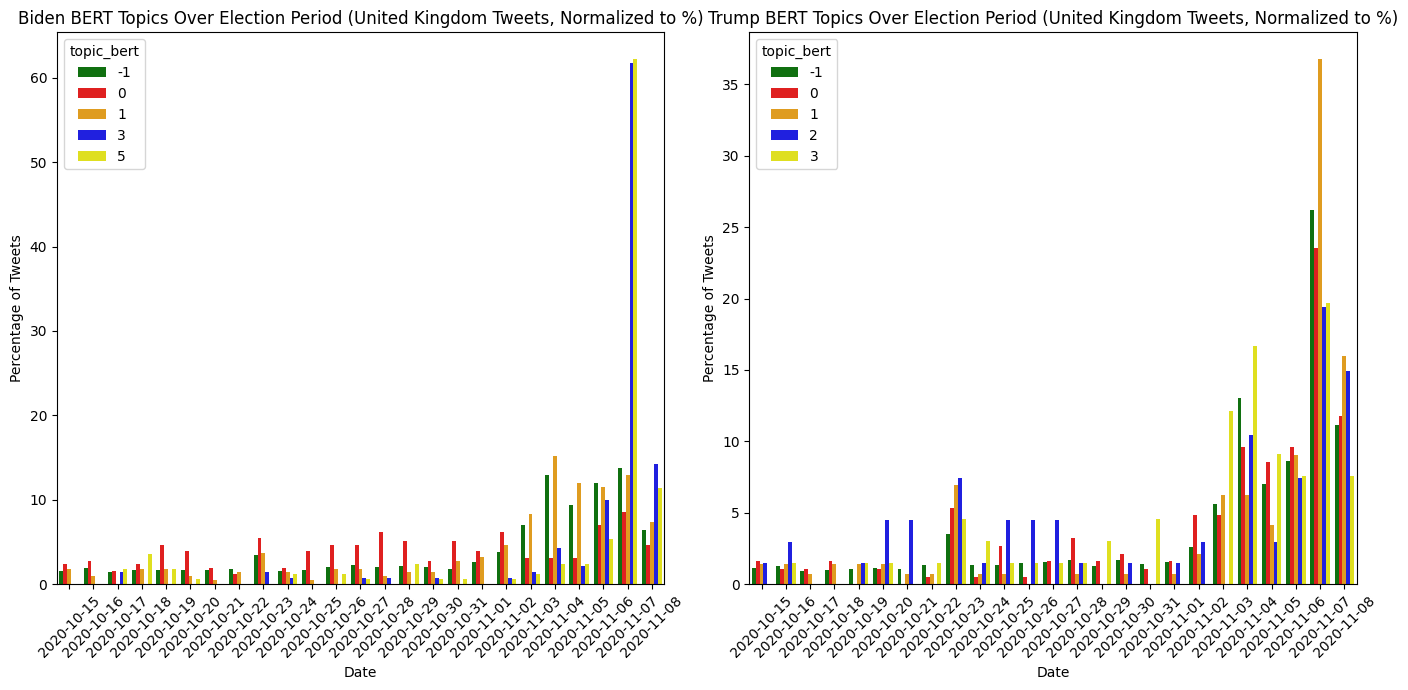

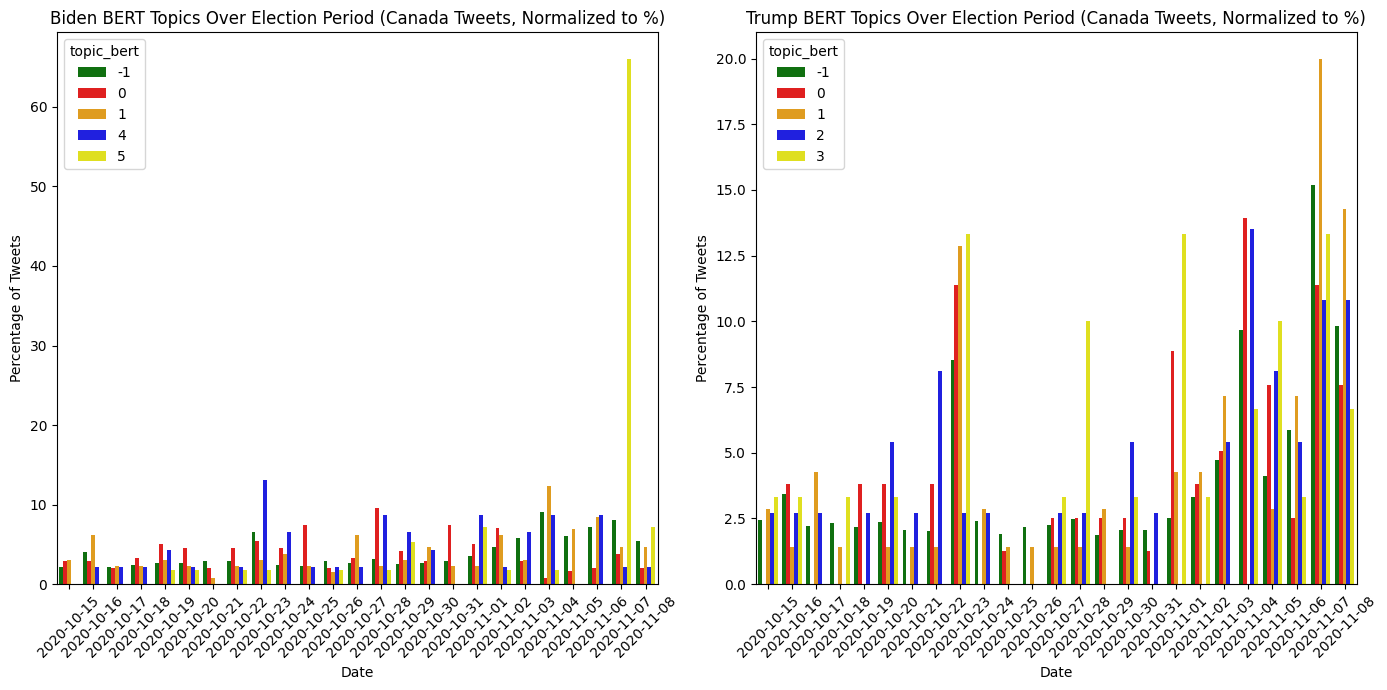

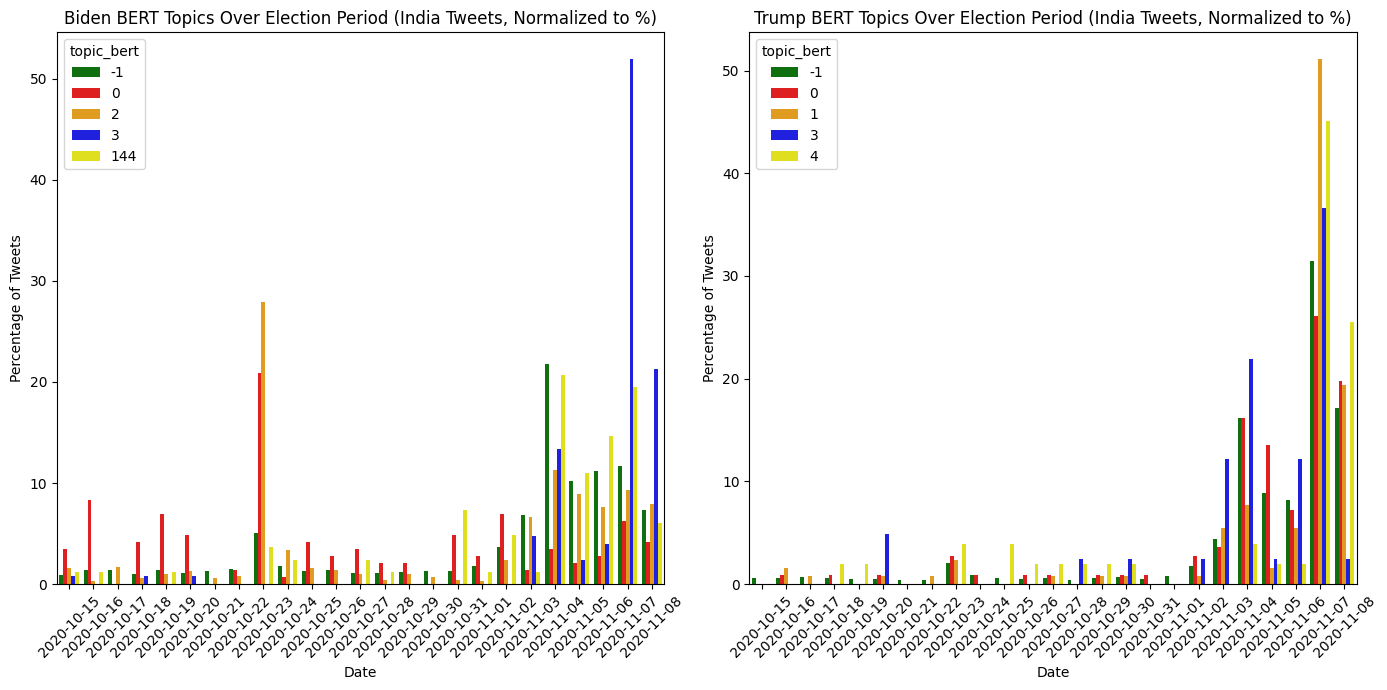

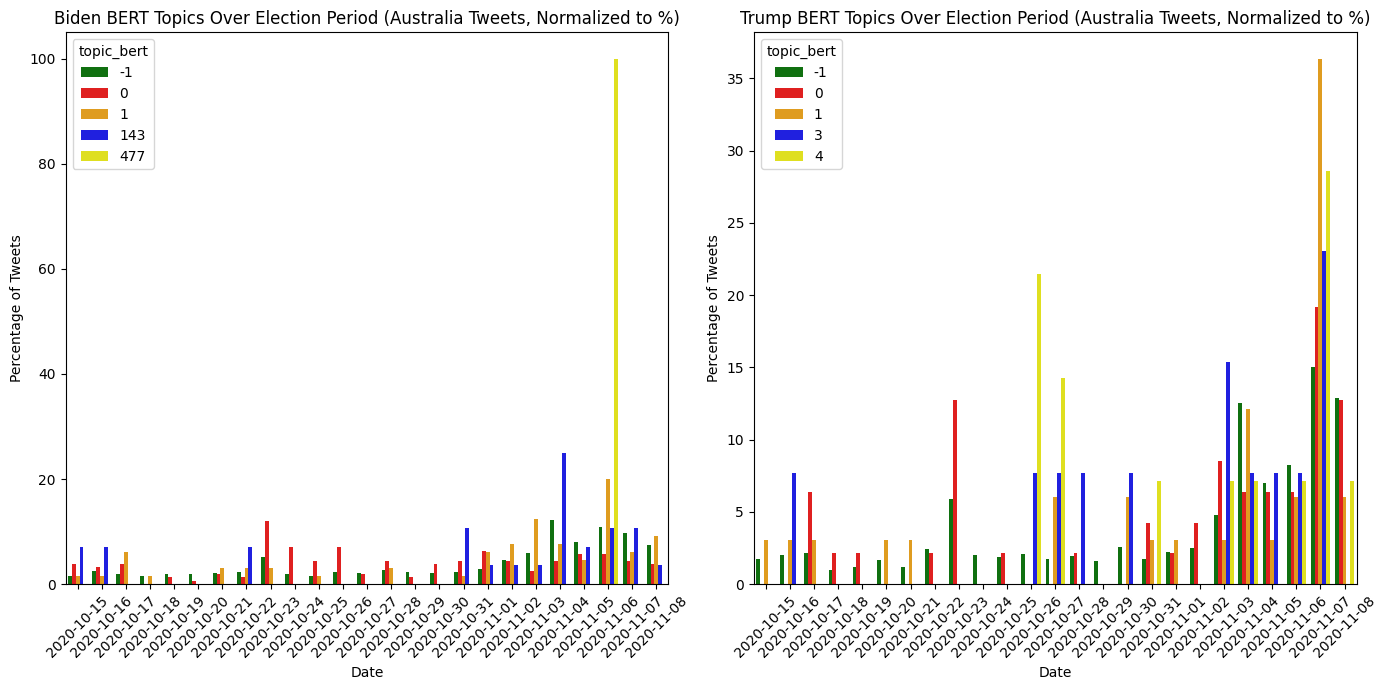

In [ ]:
#topics from UK, Canada, India, Australia


# List of countries to analyze
countries = ['United Kingdom', 'Canada', 'India', 'Australia']

# Define a color palette
custom_colors = ['green', 'red', 'orange', 'blue', 'yellow']

# Loop through each country to create bar plots for Biden and Trump
for country in countries:
    # Filter data for Biden and Trump tweets from the specified country
    country_data = df_combined[df_combined['country'] == country]
    biden_data = country_data[country_data['candidate'] == 'Joe Biden']
    trump_data = country_data[country_data['candidate'] == 'Donald Trump']

    # Identify the top 5 topics for both candidates
    top_biden_topics = biden_data['topic_bert'].value_counts().nlargest(5).index
    top_trump_topics = trump_data['topic_bert'].value_counts().nlargest(5).index

    # Filter the data for the top 5 topics
    biden_topics = biden_data[biden_data['topic_bert'].isin(top_biden_topics)]
    trump_topics = trump_data[trump_data['topic_bert'].isin(top_trump_topics)]

    # Prepare data for bar plot and normalize to percentages
    biden_topic_counts = biden_topics.groupby(['topic_bert', biden_topics['created_at'].dt.date]).size().unstack(fill_value=0)
    trump_topic_counts = trump_topics.groupby(['topic_bert', trump_topics['created_at'].dt.date]).size().unstack(fill_value=0)

    # Normalize to percentages
    biden_topic_counts_normalized = biden_topic_counts.div(biden_topic_counts.sum(axis=1), axis=0) * 100
    trump_topic_counts_normalized = trump_topic_counts.div(trump_topic_counts.sum(axis=1), axis=0) * 100

    # Melt the DataFrame for easier plotting with Seaborn
    biden_melted = biden_topic_counts_normalized.reset_index().melt(id_vars='topic_bert', var_name='date', value_name='percentage')
    trump_melted = trump_topic_counts_normalized.reset_index().melt(id_vars='topic_bert', var_name='date', value_name='percentage')

    # Plotting
    plt.figure(figsize=(14, 7))

    # Bar plot for Biden
    plt.subplot(1, 2, 1)
    sns.barplot(data=biden_melted, x='date', y='percentage', hue='topic_bert', palette=custom_colors)
    plt.title(f'Biden BERT Topics Over Election Period ({country} Tweets, Normalized to %)')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Tweets')
    plt.xticks(rotation=45)

    # Bar plot for Trump
    plt.subplot(1, 2, 2)
    sns.barplot(data=trump_melted, x='date', y='percentage', hue='topic_bert', palette=custom_colors)
    plt.title(f'Trump BERT Topics Over Election Period ({country} Tweets, Normalized to %)')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Tweets')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


Github commit

In [ ]:
df_combined.head()

candidate          created_at  \
0  Joe Biden 2020-10-15 00:00:02   
1  Joe Biden 2020-10-15 00:00:08   
2  Joe Biden 2020-10-15 00:00:17   
3  Joe Biden 2020-10-15 00:00:18   
4  Joe Biden 2020-10-15 00:00:20   

                                               tweet  retweet_count  \
0  #Trump: As a student I used to hear for years,...            1.0   
1  You get a tie! And you get a tie! #Trump ‘s ra...            3.0   
2  @CLady62 Her 15 minutes were over long time ag...            0.0   
3  @DeeviousDenise @realDonaldTrump @nypost There...            0.0   
4  One of the single most effective remedies to e...            0.0   

  user_screen_name      user_join_date      user_location country  \
0           snarke 2007-08-26 05:56:11           Portland     USA   
1        Ranaabtar 2009-06-15 19:05:35      Washington DC     USA   
2      FarrisFlagg 2013-02-01 01:37:38  Perris,California     USA   
3      sm_gulledge 2017-08-24 16:45:49          Ohio, USA     USA   
4         jamieo33 2012-03-30 00:30:54  Pennsylvania, USA     USA   

       continent                 state  ... sentiment_score_vader  \
0  North America                Oregon  ...                  68.1   
1  North America  District of Columbia  ...                  50.0   
2  North America            California  ...                  30.9   
3  North America                  Ohio  ...                  63.7   
4  North America          Pennsylvania  ...                  73.8   

   sentiment_tbl  sentiment_score_tbl  sentiment_agreement  sentiment_bert  \
0       positive                 66.7                 True        negative   
1        neutral                 50.0                 True        negative   
2       negative                 44.6                 True        negative   
3       positive                 52.5                 True        negative   
4       positive                 55.5                 True        negative   

   sentiment_score  topic_lda topic_bert user_age_group representative_word  
0         0.013582          1         -1         <1year            election  
1         0.033794          4         34         <1year              people  
2         0.003601          3         -1         <1year            election  
3         0.070799          1         -1         <1year            election  
4         0.050497          2         -1         <1year            election  

[5 rows x 34 columns]

In [ ]:
df_combined.columns

Index(['candidate', 'created_at', 'tweet', 'retweet_count', 'user_screen_name',
       'user_join_date', 'user_location', 'country', 'continent', 'state',
       'state_code', 'tweet_id', 'likes', 'user_id', 'user_followers_count',
       'lat', 'long', 'emojis', 'cleaned_tweet', 'detected_language',
       'tokenized_eng_tweet', 'hashtags', 'lemmatized_en_tweet',
       'sentiment_vader', 'sentiment_score_vader', 'sentiment_tbl',
       'sentiment_score_tbl', 'sentiment_agreement', 'sentiment_bert',
       'sentiment_score', 'topic_lda', 'topic_bert', 'user_age_group',
       'representative_word'],
      dtype='object')

In [ ]:
df_combined['state_code'].value_counts()

state_code
CA     49009
NY     36987
ENG    36103
TX     26251
FL     23840
       ...  
LT         1
MPL        1
GOU        1
U          1
BO         1
Name: count, Length: 286, dtype: int64

In [ ]:
df_combined.dtypes

candidate                        object
created_at               datetime64[ns]
tweet                            object
retweet_count                   float64
user_screen_name                 object
user_join_date           datetime64[ns]
user_location                    object
country                          object
continent                        object
state                            object
state_code                       object
tweet_id                          int64
likes                           float64
user_id                           int64
user_followers_count            float64
lat                             float64
long                            float64
emojis                           object
cleaned_tweet                    object
detected_language                object
tokenized_eng_tweet              object
hashtags                         object
lemmatized_en_tweet              object
sentiment_vader                  object
sentiment_score_vader           float64
sentiment_tbl                    object
sentiment_score_tbl             float64
sentiment_agreement                bool
sentiment_bert                   object
sentiment_score                 float64
topic_lda                         int64
topic_bert                        int64
user_age_group                 category
representative_word              object
dtype: object

In [ ]:
#Save dataframe to csv format

df_combined.to_csv('/content/drive/My Drive/DataAnalysisTwitterElection2020/df_combined.csv', index=False)

In [ ]:
# categorical_columns = ['candidate', 'user_location', 'country', 'state', 'state_code',
#                        'sentiment_vader', 'sentiment_tbl', 'sentiment_bert', 'user_age_group']
# for col in categorical_columns:
#     df_combined[col] = df_combined[col].astype('category')

In [ ]:
# float_columns = ['retweet_count', 'likes', 'user_followers_count', 'sentiment_score_vader',
#                  'sentiment_score_tbl', 'sentiment_score']
# for col in float_columns:
#     df_combined[col] = df_combined[col].astype('float32')

Model

In [ ]:
# # Step 1: Filter for tweets from the USA
# usa_data = df_combined[df_combined['country'] == 'USA']

# # Step 2: Select relevant features for the model
# features = usa_data[['candidate', 'state_code', 'likes', 'retweet_count',
#                      'lat', 'long', 'sentiment_vader', 'sentiment_score_vader',
#                      'sentiment_bert', 'sentiment_score', 'topic_lda', 'topic_bert']]

# # Step 3: Encode categorical variables, including sentiment
# features = pd.get_dummies(features, columns=['topic_lda', 'topic_bert', 'state_code', 'sentiment_vader', 'sentiment_bert'], drop_first=True)

# # Step 4: Display the features DataFrame
# print(features.head())

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# # Initialize the label encoder
# le = LabelEncoder()

# # Fit and transform the candidate column
# features['candidate'] = le.fit_transform(features['candidate'])


In [ ]:
# from sklearn.model_selection import train_test_split

# X = features.drop('candidate', axis=1)  # Features
# y = features['candidate']  # Target variable

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, accuracy_score

# # Initialize the model
# model = RandomForestClassifier(random_state=42)

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)

# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))


In [ ]:
# importances = model.feature_importances_
# feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
# feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# print(feature_importance_df.head(10))  # Display top 10 features
